# Expression

Analyze of the expression dataset

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
from matplotlib.lines import Line2D

mpl.rcParams['figure.dpi'] = 300
L = 15
sequences_int = range(2**L)

def reachable(s, L):
    return [(s | 2**ii) for ii in range(L) if (s | 2**ii) > s]
mutation_names = ['G339D','S371L','S373P','S375F','K417N','N440K','G446S','S477N','T478K','E484A','Q493R','G496S','Q498R','N501Y','Y505H']
mutation_colors = ["#121212", "#808080","#A6CEE3","#1F78B4","#B2DF8A","#33A02C","#FB9A99","#E31A1C","#FDBF6F","#FF7F00","#CAB2D6","#6A3D9A","#FFFF99","#B15928","#4F1530"]


In [6]:
df = pd.read_csv("../../Titeseq/results/Kds/cleaned_expression_RBD.tsv",
                 dtype={"geno":"str"}, sep="\t")
df["variant_int"] = df.geno.apply(lambda x: int(x, 2))
df = df.set_index("variant_int").reindex(range(0, 2**L)).reset_index()
df["mean_fluo_a"] = df["Mean fluorescence expression_a"]
df["mean_fluo_b"] = df["Mean fluorescence expression_b"]
df["mean_fluo_g"] = df["Mean fluorescence expression_g"]

for rep in ["a", "b", "g"]:
    df[f"expression_norm_{rep}"] = df[f"mean_fluo_{rep}"]/np.mean(df[f"mean_fluo_{rep}"])

df["expression_norm"] = (df[f"expression_norm_a"] + df[f"expression_norm_b"] + df[f"expression_norm_g"])/3
df["expression_ste"] = np.sqrt((df.expression_norm_a - df.expression_norm)**2 
                               + (df.expression_norm_b - df.expression_norm)**2
                               + (df.expression_norm_g - df.expression_norm)**2
                              )/np.sqrt(3)


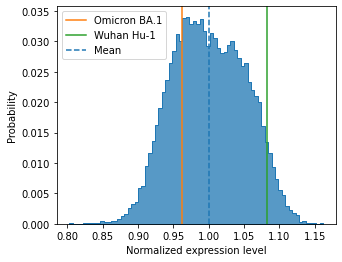

In [9]:
import matplotlib.patches as mpatches
dfp = df.copy()


sns.set_palette(sns.color_palette('tab10'))
fig,ax = plt.subplots(figsize=(5, 4))
sns.histplot(data=dfp, x="expression_norm", stat="probability",common_norm=False,ax=ax, element="step")
ax.axvline(df.set_index("geno").loc["1"*15][r"expression_norm"], 
           label="Omicron BA.1", color=sns.color_palette()[1])
ax.axvline(df.set_index("geno").loc["0"*15][r"expression_norm"], 
           label="Wuhan Hu-1", color=sns.color_palette()[2])
ax.axvline(df[r"expression_norm"].mean(), 
           label="Mean", color=sns.color_palette()[0], ls='--')
ax.set_xlabel("Normalized expression level")

plt.legend()
#ax.legend(handles, ['All variants', 'Wuhan', 'Omicron'], title='')
#plt.legend()
plt.savefig("../Figures/SI_Expression_A.pdf")

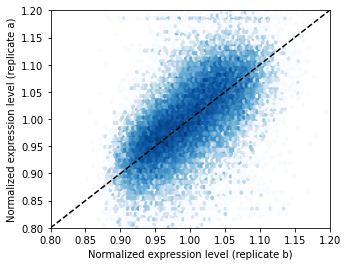

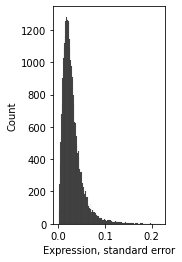

In [13]:
fig, ax1 = plt.subplots(figsize=(5,4))
ax1.hexbin(data=df, x="expression_norm_b", y="expression_norm_a", cmap="Blues", mincnt=1, bins="log")
ax1.plot([0.7, 1.3], [0.7, 1.3], c="k", ls="--")
ax1.set_xlim((0.8, 1.2))
ax1.set_ylim((0.8, 1.2))
ax1.set_xlabel("Normalized expression level (replicate b)")
ax1.set_ylabel("Normalized expression level (replicate a)")
plt.savefig("../Figures/SI_Expression_A.png", dpi=600)
plt.show()

fig, ax1 = plt.subplots(figsize=(2, 4))
sns.histplot(x="expression_ste", data=df, ax=ax1)
ax1.set_xlabel("Expression, standard error")
plt.savefig("../Figures/SI_Expression_B.pdf")
plt.show()

In [10]:
import matplotlib.transforms as transforms
from tqdm.notebook import tqdm
df["expression_ste"] = np.sqrt((df.expression_norm_a - df.expression_norm)**2 + (df.expression_norm_b - df.expression_norm)**2)/np.sqrt(2)
dft = df.set_index("geno")

dfpl = pd.DataFrame()
exprnorm = dft.expression_norm.to_dict()
errexprnorm = dft.expression_ste.to_dict()
nbmuts, deltas, muts, keeps, deltas_err, sources = [], [], [], [], [], []
for im, m in tqdm(enumerate(mutation_names)):
    muts += [m]*(len(df))
    for s in df.geno:
        deltas += [exprnorm[s] - exprnorm[s[:im] + '1' + s[im+1:]]]
        deltas_err += [np.sqrt(errexprnorm[s]**2 + errexprnorm[s[:im] + '1' + s[im+1:]]**2)]
        nbmuts += [s.count('1')]
        keeps += [s[im] != '1']
        sources += [s]

dfpl = pd.DataFrame()
dfpl["Mutation"] = muts
dfpl[r'Effect on Expression'] = deltas
dfpl[r'Effect on Expression'] = -dfpl[r'Effect on Expression']
dfpl[r'Number of mutations'] = nbmuts
dfpl[r'err_exp'] = deltas_err
dfpl[r'source'] = sources
dfpl = dfpl[keeps]

    
dfpl["Mutation"] = pd.Categorical(dfpl.Mutation, 
                      categories=mutation_names,
                      ordered=True)
dfpl = dfpl.sort_values('Mutation')

0it [00:00, ?it/s]

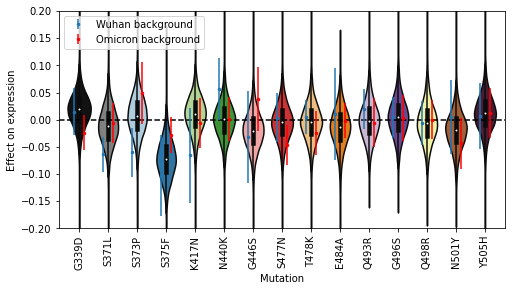

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))
offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData
sns.set_palette(mutation_colors)
sns.violinplot(data=dfpl,
            #hue="Mutation",
      x="Mutation",
      y=r'Effect on Expression', cut=0)

ax.axhline(0, ls='--', c="k")
d = dfpl[dfpl["Number of mutations"] == 0]
d = d.set_index("Mutation").reindex(mutation_names).reset_index()
ax.errorbar(x=d["Mutation"], y = d[r'Effect on Expression'], yerr = d['err_exp'], 
            label="Wuhan background", c=sns.color_palette(palette='tab10')[0], ls='', marker='.', ms=5,
            transform=trans+offset(-5))
d = dfpl[dfpl["Number of mutations"] == L-1]
d = d.set_index("Mutation").reindex(mutation_names).reset_index()
ax.errorbar(x=d["Mutation"], y = d[r'Effect on Expression'], yerr = d['err_exp'], 
            label="Omicron background", c="r", ls='', marker='.', ms=5, transform=trans+offset(+5))


plt.xticks(rotation=90)
plt.legend(loc='upper left')
plt.ylim(-0.2, 0.2)
ax.set_ylabel("Effect on expression")
plt.savefig("../Figures/SI_Expression_D.pdf")

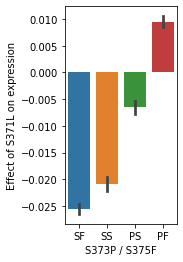

In [12]:
dfpl['S373P / S375F'] = dfpl.source.str[2:4].apply(lambda x: {'00': 'SS', '01': 'SF', '10': 'PS', '11': 'PF'}[x])

fig, ax = plt.subplots(figsize=(2, 4))
sns.barplot(data=dfpl[dfpl.Mutation == 'S371L'], x='S373P / S375F', y='Effect on Expression',
           palette=sns.color_palette('tab10'), ax=ax).set_ylabel('Effect of S371L on expression')
plt.savefig("../Figures/SI_Expression_E.pdf")